In [2]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import iris
import numpy as np
import sys
sys.path.append('/pf/b/b381639/Analysis')
import fxtian_function as fx
from iris.time import PartialDateTime
import datetime
import cf_units
import iris.coord_categorisation
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import xarray as ar

### The time coordinate in this case does not have a unit that follows this format, meaning the time coordinate will not have full time coordinate functionality
> (1) construct a new time unit based on the metadata contained in the existing time unit
> (2)take the existing time coordinate's point values and format them as datetime objects, using the format string specified in the existing time unit
> (3) convert the datetime objects from (2.) to an array of floating-point numbers using the new time unit constructed in (1.)
> (4) create a new time coordinate from the array constructed in (3.) and the new time unit produced in (1.)
> (5) remove the old time coordinate from the cube and add the new one.

In [222]:
### correct time for ICON atm
def correct_time(datain,starttime='{} since 2020-01-29 00:00:00'):
    t_coord = datain.coord('time')
    t_coord.points
    t_unit = t_coord.attributes['invalid_units']
    timestep, _, t_fmt_str = t_unit.split(' ')
    new_t_unit_str = '{} since 2020-01-29 00:00:00'.format(timestep)
    new_t_unit = cf_units.Unit(new_t_unit_str, calendar=cf_units.CALENDAR_STANDARD)
    
    datastr=t_coord.points.astype(str)
    new_datetimes = [datetime.datetime(int(dt[:4]),int(dt[4:6]),int(dt[6:8])) for dt in datastr]
    new_dt_points = [new_t_unit.date2num(new_dt) for new_dt in new_datetimes]
    new_t_coord = iris.coords.DimCoord(new_dt_points, standard_name='time', units=new_t_unit)
    
    t_coord_dim = datain.coord_dims('time')
    datain.remove_coord('time')
    datain.add_dim_coord(new_t_coord,t_coord_dim) # space before t_coord_dim is horrible
    return(datain)

In [223]:
###############################
# %%%Point to Point Regress y_cube on x_cube
########################################
## The coefficient of X in the line of regression of Y on X is called the regression coefficient of Y on X. \ 
## It represents change in the value of dependent variable (Y) corresponding to unit change in the value of \
## independent variable (X).
def regress_yonx(x_cube,y_cube,lag_min=0,lag_max=0):
    import iris
    from scipy.stats import linregress

    lags = range(lag_min,lag_max+1)
    nlags = len(lags)
    lag_coord = iris.coords.DimCoord(lags,var_name='lag_time',long_name='Lag time')
    
        #baselon = base_cube.coord('longitude').points

    lon_coord = y_cube.coord('longitude')
    lat_coord = y_cube.coord('latitude')
    nlon = len(lon_coord.points)
    nlat = len(lat_coord.points)
    
    # create a new cube to save regressed data
    regress_cube = iris.cube.Cube(np.zeros((nlags,nlat,nlon),dtype=np.float32),\
                                  dim_coords_and_dims=[[lon_coord,2],[lat_coord,1],[lag_coord,0]],\
                                  var_name='hfls_wind_p2p_regressions',\
                                  long_name='hfls_wind_point to point_regressions')
 
    for y,lat in enumerate(y_cube.coord('latitude').points):
        for t,t_slice in enumerate(y_cube[:,y,:].slices(['time'])):
            for l,lag in enumerate(lags):

                s,i,r,p,e = linregress(x_cube.data[:,y,t],np.roll(t_slice.data,-lag))

                regress_cube.data[l,y,t] = s
  

    return(regress_cube)

In [224]:
###########################
### used for select region
##########################
def selregion(cubein,lat_min,lat_max,lon_min,lon_max):
    variable_constraint = iris.Constraint(latitude=lambda cell: lat_min <= cell <= lat_max, \
                                          longitude=lambda cell: lon_min <= cell <= lon_max)
    cube_ext=cubein.extract(variable_constraint)
    return(cube_ext)

In [3]:
# %% list of data to read in
def data_dict(myid):
    if myid == 'sfcwind':
        mydict = {
            'indir': '/work/bb1153/b381639/model/data_icon',
            'infile': '/work/bb1153/b381639/model/data_icon/sfcwind_2d_ml_ocean_rm20run.nc',
            'key': iris.Constraint(cube_func=(lambda c: c.var_name == 'sfcwind'))
        }
    elif myid == 'hfls':
        mydict = {
            'indir': '/work/bb1153/b381639/model/data_icon',
            'infile': '/work/bb1153/b381639/model/data_icon/heatflux_tropics_atm_2d_ml_ocean_rm20run.nc',
            'key': iris.Constraint(cube_func=(lambda c: c.var_name == 'hfls'))
        }
    return(mydict)



In [5]:
## create correct time cubelist to save output data
cubelist_ct = iris.cube.CubeList()

##readin sfcwind
datasets=['hfls','sfcwind']  #['ERAI']  # ['u-bt405','u-bt406','u-bm213','u-be034','u-bd818']
for my_dataset in datasets:
    print('--> '+my_dataset)
    mydict = data_dict(my_dataset)
    datain = iris.load_cube(mydict['infile'],mydict['key'])
    data_time= fx.correct_time(datain)
    
    cubelist_ct.append(data_time)
    

--> hfls
--> sfcwind


/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2190: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2190: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2190: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2190: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
/sw/spac

In [7]:
#############################
##select region covers EURE4A
#############################
left = -180
right = 180
bottom = -20
top = 20
y=fx.selregion(cubelist_ct[0],bottom,top,left,right)
x=fx.selregion(cubelist_ct[1],bottom,top,left,right)
x=x[:,0,::4,::4]
y=y[:,::4,::4]

#regyonx=fx.regress_yonx(x,y)
#iris.save(regyonx,mydict['indir']+'/regress_hfls_sfcwind.nc')

In [230]:
regyonx


<iris 'Cube' of hfls_wind_point to point_regressions / (unknown) (Lag time: 1; latitude: 41; longitude: 360)>

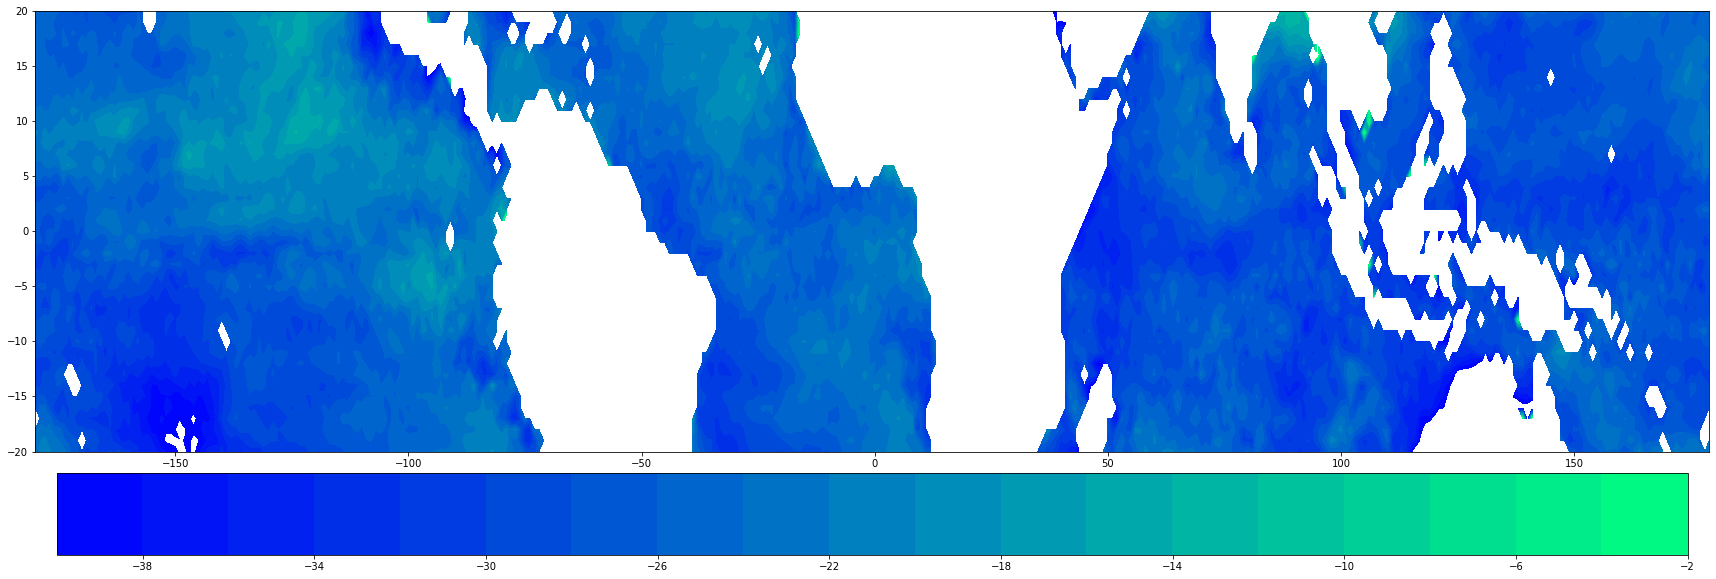

In [237]:
######################
#plot a map lat vs Lon
########################
########
#(1) get x-axis and y axis
arr=ar.DataArray.from_iris(regyonx) # iris cube to xarray
latm=arr.latitude.data              # latm is x-axis
lonm=arr.longitude.data             # lonm is y-axis  

##################
#(2)set color bar and prepare fig size
levels1=np.arange(-40,0,2) # min and max of the field; dont use it if not sure
cbar='winter'
plt.figure(figsize=(30,10))

########
#plot the figure
plt.contourf(lonm,latm,arr[0,:,:],levels=levels1,cmap = cbar)
#plt.contourf(lonm,latm,arr[0,:,:],cmap = cbar)
#plt.title('SST- ICON 5N-5S daily from 20/1/2020')
plt.colorbar(orientation='horizontal', pad=0.04)

#####save figure
plt.savefig('regress_sfcwind_on_wind.png',dpi=200)
